In [1]:
#https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import keras

from keras.regularizers import l2

Using TensorFlow backend.


In [4]:
%matplotlib inline

In [77]:
batch_size = 100
original_dim = 784
latent_dim = 50
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

import sys
print(sys.version)

3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:28:42) [MSC v.1900 64 bit (AMD64)]


#### Maximum Likelihood

Maximize the probability of each $\vec x$ in the training set:

$$
 p(\vec x^{(i)}) = \int_\mathcal Z p(\vec x^{(i)} \mid \vec z, \theta) p(\vec z) d\vec z
$$

Maximize: 
$$
  p_{\mathcal D_{train}}=\prod_i p(\vec x^{(i)}) 
$$

Equivalent to minimize:
$$
  - \log p_{\mathcal D_{train}}= - \sum_i \log p(\vec x^{(i)}) 
$$


#### Output distribution

$$
P(\vec x \mid \vec z; \theta) = \mathcal N\left(\vec x \mid f(\vec z; \theta), \sigma^2 \cdot I\right)
$$

with
- $\mathcal N$: Gaussian distribution
- $I$: Identity matrix
- $f(\vec z; \theta)$
- $\sigma^2$: Varianz (scalar); Hyperparameter

#### Encoder for training

Approximation $q(\vec z \mid \vec x)$ for true $p(\vec z \mid x)$: 

$$
 q(\vec z \mid \vec x) = \mathcal N \left( \vec z \mid \vec \mu(\vec x; \vartheta), \Sigma^2(\vec x; \vartheta) \right)
$$
with
 - $\vec \mu$: mean of multivariate Gaussian 
 - $\Sigma^2$: variances of multivariate Gaussian (restricted to a diagonal matrix)

In [69]:
x = Input(batch_shape=(batch_size, original_dim))
print(x)
h = Dense(intermediate_dim, activation='relu', kernel_regularizer=l2(0.00))(x)
print(h)

#adding one additional hidden layer 
h = Dense(intermediate_dim, activation='relu', kernel_regularizer=l2(0.00))(h)
print(h)
z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h) # exponentiation results in positive values

Tensor("input_6:0", shape=(100, 784), dtype=float32)
Tensor("dense_11/Relu:0", shape=(100, 256), dtype=float32)
Tensor("dense_12/Relu:0", shape=(100, 256), dtype=float32)


$$
\Sigma^2 = var = \exp(\log var) 
$$
$$
 \Sigma = \exp(\frac{1}{2} \log var)
$$

In [70]:
def sampling(args):
    z_mean, z_log_var = args
    # reparametrization trick
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std) # stddev -> std ??
    return z_mean + K.exp(z_log_var / 2) * epsilon


The approximation should be good in regions where $q(\vec z \mid \vec x )$ is relative high:

$$
KL \left( q(\vec z \mid \vec x ) \mid\mid  p(z\mid x) \right) = \mathbb E_{}
$$

$$
\log p(\vec x) - KL\left( q(\vec z \mid \vec x ) \mid\mid  p(\vec z\mid \vec x) \right) = 
  \mathbb E_{\vec z \sim Q} \left[ \log P(\vec x \mid \vec z)\right] - 
  KL \left[ Q(\vec z \mid \vec x) \mid \mid p(\vec z)\right]
$$

The right-hand side can be maximized via stochasitc gradient decent.

In [71]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
print(z_mean)
print(z_log_var)
print(z)

Tensor("z_mean_3/BiasAdd:0", shape=(100, 50), dtype=float32)
Tensor("z_log_var_3/BiasAdd:0", shape=(100, 50), dtype=float32)
Tensor("lambda_7/add:0", shape=(100, 50), dtype=float32)


#### Decoder 

In [73]:
# we instantiate these layers separately so as to reuse them later
decoder_h1 = Dense(intermediate_dim, activation='relu')
decoder_h2 = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h1_decoded = decoder_h1(z)
h2_decoded = decoder_h2(h1_decoded)
x_decoded_mean = decoder_mean(h2_decoded)

print(h1_decoded)
print(h2_decoded)
print(x_decoded_mean)

Tensor("dense_15/Relu:0", shape=(100, 256), dtype=float32)
Tensor("dense_16/Relu:0", shape=(100, 256), dtype=float32)
Tensor("decoder_mean_3/Sigmoid:0", shape=(100, 784), dtype=float32)


#### Loss

Kullback Leibler Loss:

$$
KL \left[ q(\vec z \mid \vec x) \mid \mid p(\vec z)\right]
$$

Both distribution are Gaussian:
 - $q(\vec z \mid \vec x) = \mathcal N \left( \vec \mu(\vec x; \vartheta), \Sigma^2(\vec x; \vartheta) \right)$
 - $p(\vec z) = \mathcal N \left( 0, I \right)$
 
So  
$$
KL \left[ q(\vec z \mid \vec x) \mid \mid p(\vec z)\right] = \frac{1}{2} 
\left( \text{tr} (\Sigma(\vec x))\ +\mu(\vec x) ^T \left( \mu(\vec x) - k - \log \det(\Sigma(\vec x) \right) \right)
$$

In [74]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
print(vae)

In [75]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [76]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s - loss: 167.3737 - val_loss: 141.0457
Epoch 2/50
60000/60000 [==============================] - 5s - loss: 133.8496 - val_loss: 124.1896
Epoch 3/50
60000/60000 [==============================] - 5s - loss: 122.8235 - val_loss: 117.7901
Epoch 4/50
60000/60000 [==============================] - 5s - loss: 117.2623 - val_loss: 113.6419
Epoch 5/50
60000/60000 [==============================] - 5s - loss: 113.7673 - val_loss: 111.8732
Epoch 6/50
60000/60000 [==============================] - 5s - loss: 111.6104 - val_loss: 111.5476
Epoch 7/50
60000/60000 [==============================] - 5s - loss: 110.0921 - val_loss: 109.7281
Epoch 8/50
60000/60000 [==============================] - 5s - loss: 108.9430 - val_loss: 107.5420
Epoch 9/50
60000/60000 [==============================] - 5s - loss: 108.0505 - val_loss: 107.0459
Epoch 10/50
60000/60000 [==============================] - 

KeyboardInterrupt: 

### Supervised Learning

In [52]:
num_classes = 10
intermediate_classifier_dim = 75

In [53]:
nb_train_examples = len(x_train)
#label_percentage = 0.01
#mask = np.random.binomial(1, label_percentage, size=(nb_train_examples))
#mask.sum()

In [54]:
nb_labeled_examples = 600
mask = np.concatenate((np.ones(nb_labeled_examples, dtype=int), np.zeros(59400, dtype=int)))
mask = np.random.permutation(mask)


In [55]:
# convert class vectors to binary class matrices
y_train_ = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test_ = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [56]:
y_train_[mask==0] = np.zeros(y_train_[mask==0].shape)

In [57]:
y_train__ = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_train__ = y_train__[mask==1]
x_train__ = x_train[mask==1]

In [58]:
y_train__id = y_train[mask==1]

In [59]:
x_train__.shape

(600, 784)

In [25]:

h_classifier = Dense(intermediate_classifier_dim, activation='relu', 
                     name="intermediate_classifier",  W_regularizer=l2(0.00))(z)
y_pred = Dense(num_classes, activation='softmax', name="y_pred")(h_classifier)

C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(75, kernel_regularizer=<keras.reg..., activation="relu", name="intermediate_classifier")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
vae_semi = Model(input=[x],output=[x_decoded_mean, y_pred])

C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [27]:
def z_distance_from_origin(dummy, z):
    distance_from_origin = K.sum(K.square(z), axis=-1)
    return K.maximum(.5 - distance_from_origin, 0.)
    #return K.abs(distance_from_origin - .15)

In [28]:
supervised_loss = metrics.categorical_crossentropy

In [29]:
alpha = 0.1 * nb_labeled_examples

In [64]:
vae_semi.compile(optimizer='adam', loss=[vae_loss, supervised_loss], loss_weights=[1., alpha],
                metrics={'y_pred':'accuracy'})

print(x_train.shape)
print(y_train_.shape)

(60000, 784)
(60000, 50)


In [65]:
vae_semi.fit([x_train], [x_train, y_train_],
        shuffle=True,
        nb_epoch=100,
        batch_size=batch_size,
        validation_data=(x_train__, [x_train__, y_train__]))

C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 600 samples
Epoch 1/100


InvalidArgumentError: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [100,784]
	 [[Node: input_5 = Placeholder[dtype=DT_FLOAT, shape=[100,784], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_decoder_mean_target_6_0 = _Recv[client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-381640968361505473, tensor_name="decoder_mean_target_6:0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_5', defined at:
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-40953b7959f1>", line 1, in <module>
    x = Input(batch_shape=(batch_size, original_dim))
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 1388, in Input
    input_tensor=tensor)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 1299, in __init__
    name=self.name)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 349, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1507, in placeholder
    name=name)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\RobNoFlop\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_5' with dtype float and shape [100,784]
	 [[Node: input_5 = Placeholder[dtype=DT_FLOAT, shape=[100,784], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_decoder_mean_target_6_0 = _Recv[client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-381640968361505473, tensor_name="decoder_mean_target_6:0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


#### Plot the results

In [34]:
vae_semi.evaluate(x_test, [x_test, y_test_], verbose=0, batch_size=100)

[193.93194427490235,
 138.94308891296387,
 0.91648092687129978,
 0.7826999884843826]

In [35]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean) # z_log_var??

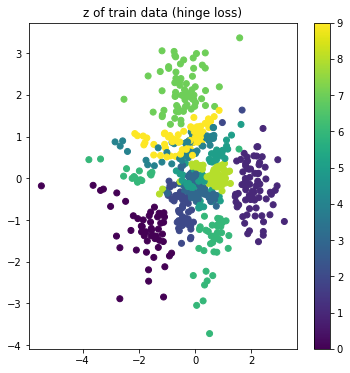

In [36]:
# display a 2D plot of the train digit classes in the latent space
x_train_encoded = encoder.predict(x_train__, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train__id)
plt.colorbar()
plt.title("z of train data (hinge loss)")
plt.show()

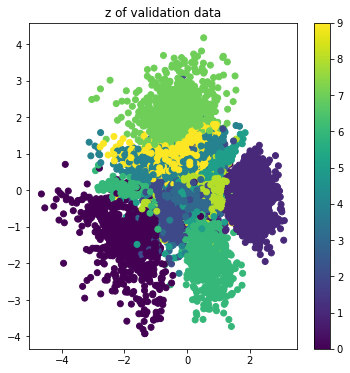

In [37]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.title("z of validation data")
plt.show()

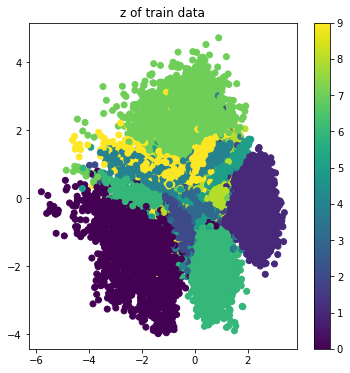

In [38]:
# display a 2D plot of the train digit classes in the latent space
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train)
plt.colorbar()
plt.title("z of train data")
plt.show()

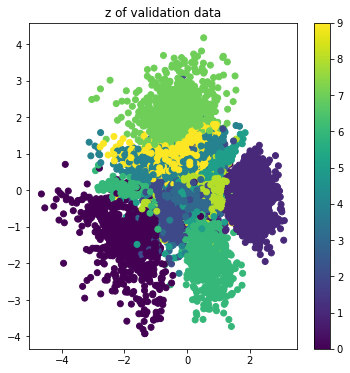

In [39]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.title("z of validation data")
plt.show()

In [43]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h2(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

ValueError: Input 0 is incompatible with layer dense_4: expected axis -1 of input shape to have value 256 but got shape (None, 2)

In [41]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


In [42]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


NameError: name 'generator' is not defined

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
#### Baseline 

#### Literatur:

- Diederik P. Kingma, Danilo J. Rezende, Shakir Mohamed, Max Welling: Semi-Supervised Learning with Deep Generative Models, https://arxiv.org/abs/1406.5298